In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
import pandas as pd
import plotly.express as px


mpl.rcParams['figure.figsize'] = (10, 8)
mpl.rcParams['axes.grid'] = False

In [2]:
def parse(x):
	return datetime.strptime(x, '%m/%d/%Y')

In [3]:
df = pd.read_csv('electricity_consumption.csv', parse_dates = ['Bill_Date'],date_parser=parse)
df.head()

,Bill_Date,On_peak,Off_peak,Usage_charge,Billed_amount,Billing_days
0,2016-01-01,365,1423.5,219.0,247.73,31
1,2016-02-01,292,1138.8,175.2,234.11,31
2,2016-03-01,130,507.0,78.0,123.85,29
3,2016-04-01,117,456.3,70.2,111.22,29
4,2016-05-01,136,530.4,81.6,118.37,29


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53 entries, 0 to 52
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Bill_Date      53 non-null     datetime64[ns]
 1   On_peak        53 non-null     int64         
 2   Off_peak       53 non-null     float64       
 3   Usage_charge   53 non-null     float64       
 4   Billed_amount  53 non-null     float64       
 5   Billing_days   53 non-null     int64         
dtypes: datetime64[ns](1), float64(3), int64(2)
memory usage: 2.6 KB


## Set data and time as an index 

In [5]:
df = df.set_index('Bill_Date')
df.head()

,On_peak,Off_peak,Usage_charge,Billed_amount,Billing_days
Bill_Date,,,,,
2016-01-01,365,1423.5,219.0,247.73,31
2016-02-01,292,1138.8,175.2,234.11,31
2016-03-01,130,507.0,78.0,123.85,29
2016-04-01,117,456.3,70.2,111.22,29
2016-05-01,136,530.4,81.6,118.37,29


In [6]:
df.tail()

,On_peak,Off_peak,Usage_charge,Billed_amount,Billing_days
Bill_Date,,,,,
2020-01-01,211,1761.0,231.71,251.85,31
2020-02-01,190,1635.0,210.86,229.18,32
2020-03-01,151,1179.0,156.56,170.16,29
2020-04-01,75,625.0,87.27,94.85,29
2020-05-01,147,686.0,124.39,135.19,29


In [7]:
df_2016 = df['2016':'2019'][['Billed_amount']]
df_2016.head()

,Billed_amount
Bill_Date,
2016-01-01,247.73
2016-02-01,234.11
2016-03-01,123.85
2016-04-01,111.22
2016-05-01,118.37


## Simple moving average 
- try to smooth out the trend and other curve 

In [8]:
df_2016['Rolling_3'] = df_2016['Billed_amount'].rolling(window=3).mean()

In [9]:
df_2016.head()

,Billed_amount,Rolling_3
Bill_Date,,
2016-01-01,247.73,NaN
2016-02-01,234.11,NaN
2016-03-01,123.85,201.896667
2016-04-01,111.22,156.393333
2016-05-01,118.37,117.813333


<AxesSubplot:xlabel='Bill_Date'>

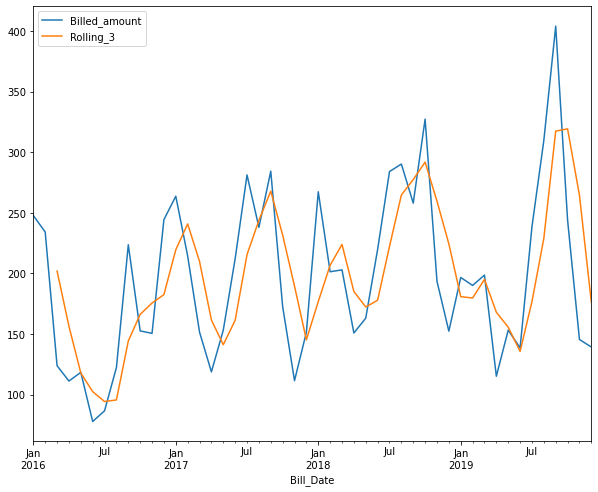

In [10]:
df_2016.plot()

# Wieghted moving average 
- here we assign weight to each time stamp and than try to smooth out the curve 
- we don't have built in fn that's why we are witting it's own 

In [11]:
def wma(weights): 
  def calc(x):
    return (weights*x).mean()
  return calc

####  here we assign first weight as 1.5 and 1 and so on
- window size is 3, that's why we are passing the 3 values in np array 

In [12]:
df_2016['Wieghted MA'] = df_2016['Billed_amount'].rolling(window=3).apply(wma(np.array([0.5,1,1.5])))

#### Here we can see that the the weighted ma covers and follow the original value more accurately as compared to the the simple moving average 

<AxesSubplot:xlabel='Bill_Date'>

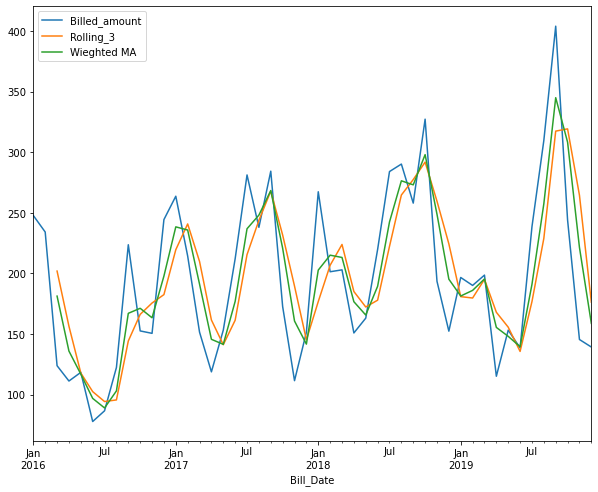

In [13]:
df_2016.plot()

## Exponential moving average
formula = (Close - previous EMA) * (2/(span+1)) + previous EMA
- similar to the weighted average but here we don't need to provide weights 
- we have two factors here 
   - span (the time period for which we want to calculate)
   - alpha (smoothing factor val between 0 and 1) 

In [23]:
df_2016['span_ewma'] = df_2016['Billed_amount'].ewm(span=3, adjust=False).mean()

In [24]:
df_2016.head()

,Billed_amount,Rolling_3,Wieghted MA,span_ewma
Bill_Date,,,,
2016-01-01,247.73,NaN,NaN,247.73000
2016-02-01,234.11,NaN,NaN,240.92000
2016-03-01,123.85,201.896667,181.250000,182.38500
2016-04-01,111.22,156.393333,135.911667,146.80250
2016-05-01,118.37,117.813333,116.900000,132.58625


<AxesSubplot:xlabel='Bill_Date'>

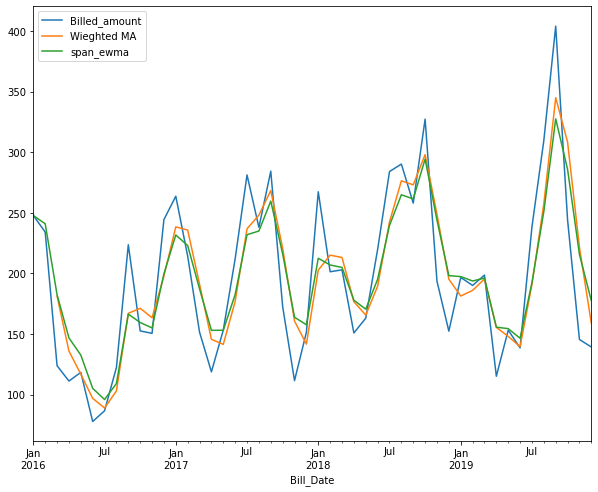

In [25]:
df_2016[['Billed_amount', 'Wieghted MA', 'span_ewma']].plot()

# Exponential Smoothing 
- high value give priority to recent data 
- low value give importance to the history data 

![alt text](https://people.duke.edu/~rnau/411avg_files/image028.png)

In [29]:
df_2016['alpha_ewma_0.7'] = df_2016['Billed_amount'].ewm(alpha=0.7, adjust=False, min_periods=3).mean()
df_2016['alpha_ewma_0.3'] = df_2016['Billed_amount'].ewm(alpha=0.3, adjust=False,min_periods=3).mean()

In [30]:
df_2016.head()

,Billed_amount,Rolling_3,Wieghted MA,span_ewma,alpha_ewma_0.7,alpha_ewma_0.3
Bill_Date,,,,,,
2016-01-01,247.73,NaN,NaN,247.73000,NaN,NaN
2016-02-01,234.11,NaN,NaN,240.92000,NaN,NaN
2016-03-01,123.85,201.896667,181.250000,182.38500,158.153800,207.705800
2016-04-01,111.22,156.393333,135.911667,146.80250,125.300140,178.760060
2016-05-01,118.37,117.813333,116.900000,132.58625,120.449042,160.643042


<AxesSubplot:xlabel='Bill_Date'>

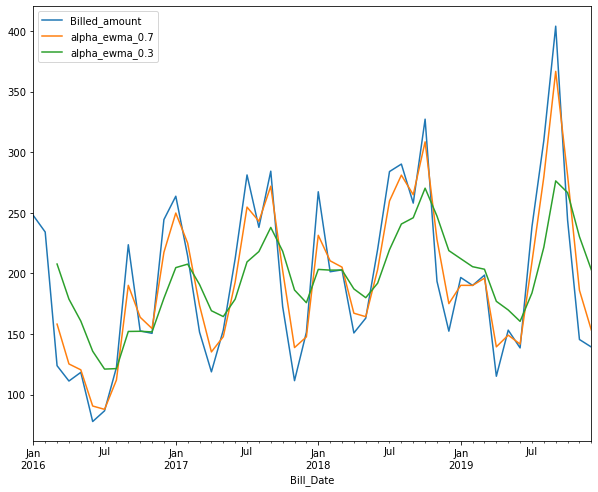

In [31]:
df_2016[['Billed_amount', 'alpha_ewma_0.7', 'alpha_ewma_0.3']].plot()

# RSMW (root squared mean error)
#### Here we will try to find out the resisduals between the acutall and predicted moving average 

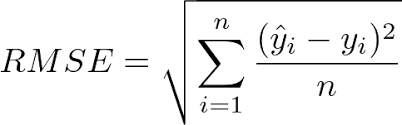

## Rolling window 

In [35]:
((df_2016['Billed_amount']- df_2016['Rolling_3'])**2).mean()**0.5

49.9479576526558

In [37]:
((df_2016['Billed_amount']- df_2016['Wieghted MA'])**2).mean()**0.5

35.21772182689177

In [38]:
((df_2016['Billed_amount']- df_2016['span_ewma'])**2).mean()**0.5

34.590335017362044

In [39]:
((df_2016['Billed_amount']- df_2016['alpha_ewma_0.7'])**2).mean()**0.5

20.495740136513554

In [40]:
((df_2016['Billed_amount']- df_2016['alpha_ewma_0.3'])**2).mean()**0.5

51.007880591700015

### We will choose the alpha 0.7 bcz the error rate is less for this moving average 

In [36]:
df_2016.head()

,Billed_amount,Rolling_3,Wieghted MA,span_ewma,alpha_ewma_0.7,alpha_ewma_0.3
Bill_Date,,,,,,
2016-01-01,247.73,NaN,NaN,247.73000,NaN,NaN
2016-02-01,234.11,NaN,NaN,240.92000,NaN,NaN
2016-03-01,123.85,201.896667,181.250000,182.38500,158.153800,207.705800
2016-04-01,111.22,156.393333,135.911667,146.80250,125.300140,178.760060
2016-05-01,118.37,117.813333,116.900000,132.58625,120.449042,160.643042
